<a href="https://colab.research.google.com/github/PedroOlavo/ArtigosMedium/blob/main/Energia_renov%C3%A1vel_nas__regi%C3%B5es_brasileiras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise das usinas geradoras de energia elétrica renovável no Brasil


Neste notebook analisarei uma base de dados disponibilizada pela ANEEL, a Agência Nacional de Energia Elétrica, em seu site.

Tentarei descobrir as diferenças na geração em cada região, se algum tipo de usina é mais presente em uma região do que em outras e afins.

Para começar, as bibliotecas necessárias serão importadas sendo elas:


*   Pandas, para visualizar e trabalhar os dados;
*   Matplotlib, permite que customize as visualizações gráficas;
*   Seaborn, biblioteca que contém diversos gráficos úteis para análises.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Então mãos à obra.

O estudo é iniciado carregando o banco de dados.

In [13]:
dados = pd.read_excel('/content/drive/MyDrive/BD SIGA 01012021.xlsx', header=1)
dados.head()

,Empreendimento,CEG,UF,Fonte,Fase,Origem,Tipo,Tipo de Atuação,Combustível Final,Entrada em Operação,Potência Outorgada (kW),Potência Fiscalizada (kW),Garantia Fisica (kW),Geração Qualificada,Latitude (GMS),Longitude (GMS),Início Vigência,Fim Vigência,Proprietário / Regime de Exploração,Cod e Desc Sub-Bacia,Município (s)
0,14 de Julho,UHE.PH.RS.000012-4,RS,UHE,Operação,Hídrica,Potencial hidráulico,Concessão,Potencial hidráulico,25/12/2008,100000.0,100710.0,47500,Não,"29°3'53,136""S","51°40'29,824""W",2001-03-15,2036-03-15,100% para COMPANHIA ENERGÉTICA RIO DAS ANTAS (...,86 - Taquari,"Bento Gonçalves - RS, Cotiporã - RS"
1,29 de Outubro,UTE.PE.SC.029920-0,SC,UTE,Operação,Fóssil,Petróleo,Registro,Óleo Diesel,07/10/2008,62.0,62.0,0,Não,"26° 29' 9,370"" S","49° 5' 10,100"" W",NaT,NaT,100% para Condomínio Residencial 29 de Outubro...,NaN,Jaraguá do Sul - SC
2,300KVA SCANIA,UTE.PE.MG.032686-0,MG,UTE,Operação,Fóssil,Petróleo,Registro,Óleo Diesel,01/06/2013,240.0,240.0,0,Não,"21°46'53,08""S","46°36'22,97""W",NaT,NaT,100% para Mineração Curimbaba Ltda. (REG),NaN,Poços de Caldas - MG
3,3M Itapetininga,UTE.PE.SP.028642-7,SP,UTE,Operação,Fóssil,Petróleo,Registro,Óleo Diesel,12/06/2002,3840.0,3840.0,0,Não,"23°36'3,19""S","48°5'41,69""W",NaT,NaT,100% para 3M do Brasil Ltda (REG),NaN,Itapetininga - SP
4,3M Sumaré,UTE.PE.SP.028919-1,SP,UTE,Operação,Fóssil,Petróleo,Autorização,Óleo Diesel,01/10/2001,6400.0,6400.0,0,Não,"22°49'15,73""S","47°11'24,3""W",2003-06-20,2033-06-20,100% para 3M do Brasil Ltda (APE),NaN,Sumaré - SP


É visível que diversas colunas que estão presentes no dataset não serão necessárias, por isso a base de dados será carregada novamente a fim de conter apenas as colunas principais.

In [14]:
dados = pd.read_excel('/content/drive/MyDrive/BD SIGA 01012021.xlsx',
                      skiprows = [0],
                      usecols = ['UF', 'Fase', 'Fonte', 'Origem',
                                 'Potência Outorgada (kW)'])
dados.head()

,UF,Fonte,Fase,Origem,Potência Outorgada (kW)
0,RS,UHE,Operação,Hídrica,100000.0
1,SC,UTE,Operação,Fóssil,62.0
2,MG,UTE,Operação,Fóssil,240.0
3,SP,UTE,Operação,Fóssil,3840.0
4,SP,UTE,Operação,Fóssil,6400.0


In [15]:
dados['Fase'].value_counts()

Operação                   9042
Construção não iniciada     699
Construção                  257
Name: Fase, dtype: int64

A coluna Fase nos apresenta em qual estágio está a usina, se em operação, construção ou se a construção ainda não foi iniciada.

Neste caso nosso interesse se dá apenas nas usinas em operação, por isso faremos um corte nos dados, a fim de contar apenas com as usinas que já trabalham.

In [16]:
dados = dados.loc[dados['Fase']=='Operação']
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9042 entries, 0 to 9997
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UF                       9042 non-null   object 
 1   Fonte                    9042 non-null   object 
 2   Fase                     9042 non-null   object 
 3   Origem                   9042 non-null   object 
 4   Potência Outorgada (kW)  9042 non-null   float64
dtypes: float64(1), object(4)
memory usage: 423.8+ KB


Agora a coluna Potência será renomeada apenas por conveniência. 

In [17]:
dados.rename(columns={'Potência Outorgada (kW)': 'Potência_kW'}, inplace=True)

Em seguida é preciso saber quais são os tipos de usinas presentes nos dados, pois a análise se aterá apenas as formas de geração renováveis.

In [18]:
dados['Origem'].unique()

array(['Hídrica', 'Fóssil', 'Solar', 'Eólica', 'Biomassa', 'Nuclear',
       'Undi-Elétrica'], dtype=object)

Das origens listadas acima, apenas duas não se enquadram no objetivo, sendo elas a geração por meio de combustíveis fósseis e a geração nuclear, por isso essas usinas serão retiradas dos dados.

In [19]:
renovaveis = dados['Origem'] != 'Fóssil'
dados = dados[renovaveis]

In [20]:
renovaveis = dados['Origem'] != 'Nuclear'
dados = dados[renovaveis]
dados = dados.reset_index()

In [21]:
dados.Origem.unique()

array(['Hídrica', 'Solar', 'Eólica', 'Biomassa', 'Undi-Elétrica'],
      dtype=object)

Feita a retiradaa das usians que não são de interesse é necessário definir qual a região em que cada unidade geradora se encontra, para isso será feito um dicionário contendo as regiões e seus respectivos estados e posteriormente uma função será definida com intuito de criar uma coluna contendo a região de cada usina.

In [22]:
sudeste = ['MG', 'SP', 'RJ', 'ES']

norte = ['AM', 'RR', 'AC', 'AP', 'PA', 'TO', 'RO']

cen_oeste = ['GO', 'MT', 'MS', 'DF']

nordeste = ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE']

sul = ['PR', 'SC', 'RS']

regiões = {'Sudeste': sudeste, 'Norte': norte, 'Centro-Oeste': cen_oeste, 'Nordeste': nordeste, 'Sul': sul}

In [23]:
def reg(estado):
    for regiao, estados in regiões.items():
        if estado in estados:
            return regiao

dados['Regiao'] = dados.UF.apply(reg)

In [24]:
dados.head()

,index,UF,Fonte,Fase,Origem,Potência_kW,Regiao
0,0,RS,UHE,Operação,Hídrica,100000.0,Sul
1,14,RS,CGH,Operação,Hídrica,720.0,Sul
2,17,PA,UFV,Operação,Solar,1.0,Norte
3,18,PA,UFV,Operação,Solar,1.0,Norte
4,19,PA,UFV,Operação,Solar,1.0,Norte


Acima é possível ver que a função região funcionou perfeitamente, adicionando assim a informação sobre em qual parte do país se encontra a unidade de geração.

Em seguida as usinas de cada região serão contabilizadas, levanto em consideração seu tipo, podendo ser solar, hídrica e afins.

In [25]:
for i in dados['Regiao']:
  if i == 'Sul':
    usi_sul = dados.loc[dados['Regiao']==i].Origem.value_counts()
  elif i == 'Sudeste':
    usi_sud = dados.loc[dados['Regiao']==i].Origem.value_counts()
  elif i == 'Norte':
    usi_nor = dados.loc[dados['Regiao']==i].Origem.value_counts()
  elif i == 'Nordeste':
    usi_ndt = dados.loc[dados['Regiao']==i].Origem.value_counts()
  elif i == 'Centro-Oeste':
    usi_cen = dados.loc[dados['Regiao']==i].Origem.value_counts()

Finalmente os gráficos contendo a quantiade de usinas e seus tipos em cada região podem ser gerados.

Abaixo cada gráfico se refere a uma região brasileira, iniciando pelo Centro-Oeste.


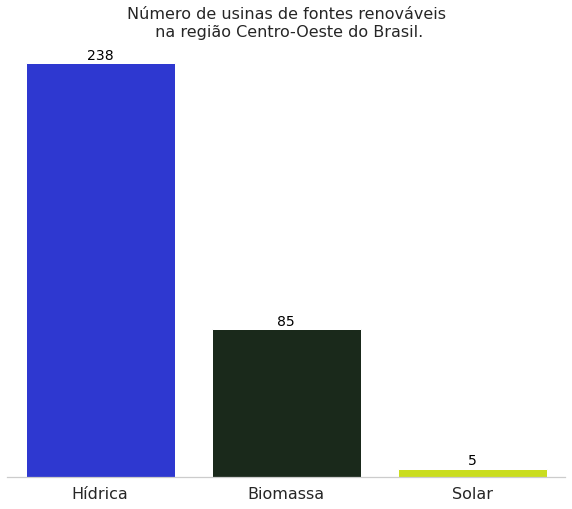

In [34]:
plt.figure(figsize=(10,8), dpi=72)
sns.set(style='whitegrid')
sns.barplot(x=['Hídrica', 'Biomassa','Solar'], y=[usi_cen.Hídrica, usi_cen.Biomassa, usi_cen.Solar],
            palette=['#1321eb','#172b19','#e3fc00'])
sns.despine(left=True)
plt.yticks([],[])
plt.title('Número de usinas de fontes renováveis' '\n na região Centro-Oeste do Brasil.', size=16)
plt.xticks(size=16)
plt.text(x=0, y=240, s='238',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=1, y=87, s='85',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=2, y=7, s='5',
         color='black', fontsize=14, horizontalalignment='center')
plt.show()

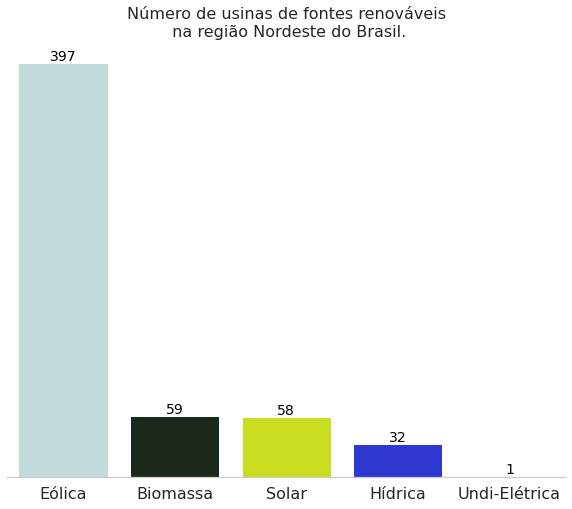

In [35]:
plt.figure(figsize=(10,8), dpi=72)
sns.set(style='whitegrid')
sns.barplot(x=['Eólica', 'Biomassa', 'Solar','Hídrica', 'Undi-Elétrica'], y=[usi_ndt.Eólica, usi_ndt.Biomassa, usi_ndt.Solar, usi_ndt.Hídrica, usi_ndt[4]],
            palette=['#bce0de','#172b19','#e3fc00','#1321eb', '#00144d'])
sns.despine(left=True)
plt.yticks([],[])
plt.title('Número de usinas de fontes renováveis' '\n na região Nordeste do Brasil.', size=16)
plt.xticks(size=16)
plt.text(x=0, y=399, s='397',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=1, y=61, s='59',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=2, y=60, s='58',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=3, y=34, s='32',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=4, y=3, s='1',
         color='black', fontsize=14, horizontalalignment='center')
plt.show()

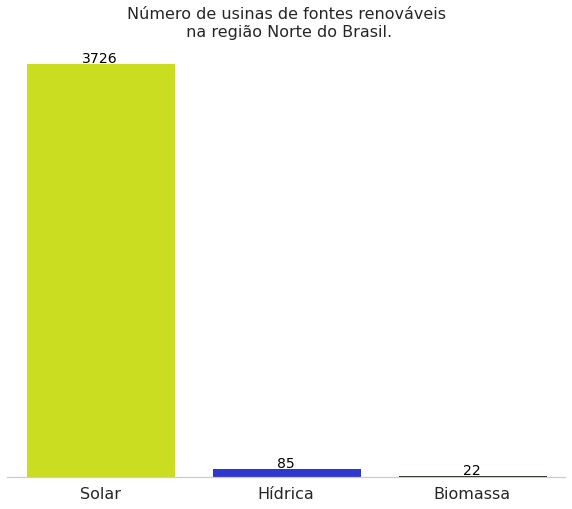

In [36]:
plt.figure(figsize=(10,8), dpi=72)
sns.set(style='whitegrid')
sns.barplot(x=['Solar', 'Hídrica','Biomassa'], y=[usi_nor.Solar, usi_nor.Hídrica, usi_nor.Biomassa],
            palette=['#e3fc00','#1321eb','#172b19'])
sns.despine(left=True)
plt.yticks([],[])
plt.title('Número de usinas de fontes renováveis' '\n na região Norte do Brasil.', size=16)
plt.xticks(size=16)
plt.text(x=0, y=3728, s='3726',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=1, y=87, s='85',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=2, y=24, s='22',
         color='black', fontsize=14, horizontalalignment='center')
plt.show()

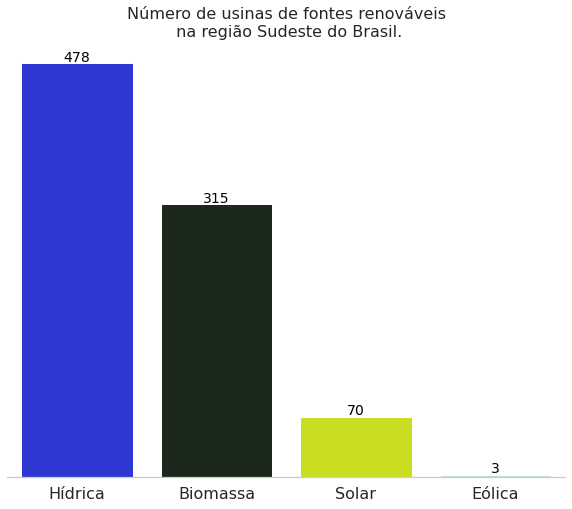

In [37]:
plt.figure(figsize=(10,8), dpi=72)
sns.set(style='whitegrid')
sns.barplot(x=['Hídrica', 'Biomassa', 'Solar','Eólica'], y=[usi_sud.Hídrica, usi_sud.Biomassa, usi_sud.Solar, usi_sud.Eólica],
            palette=['#1321eb','#172b19','#e3fc00','#bce0de'])
sns.despine(left=True)
plt.yticks([],[])
plt.title('Número de usinas de fontes renováveis' '\n na região Sudeste do Brasil.', size=16)
plt.xticks(size=16)
plt.text(x=0, y=480, s='478',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=1, y=317, s='315',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=2, y=72, s='70',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=3, y=5, s='3',
         color='black', fontsize=14, horizontalalignment='center')
plt.show()

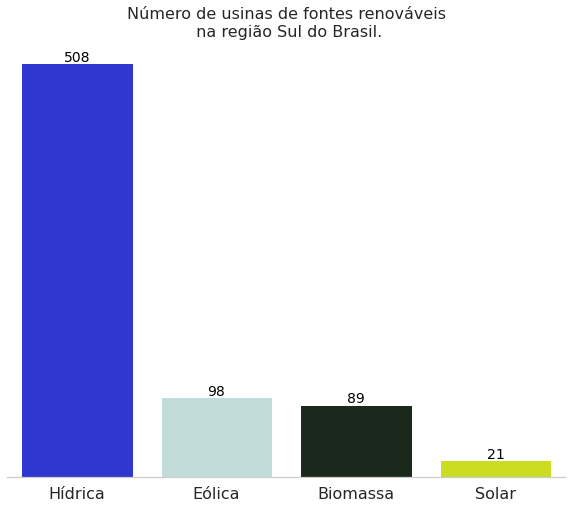

In [38]:
plt.figure(figsize=(10,8), dpi=72)
sns.set(style='whitegrid')
sns.barplot(x=['Hídrica', 'Eólica', 'Biomassa','Solar'], y=[usi_sul.Hídrica, usi_sul.Eólica, usi_sul.Biomassa, usi_sul.Solar],
            palette=['#1321eb','#bce0de','#172b19','#e3fc00'])
sns.despine(left=True)
plt.yticks([],[])
plt.title('Número de usinas de fontes renováveis' '\n na região Sul do Brasil.', size=16)
plt.xticks(size=16)
plt.text(x=0, y=510, s='508',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=1, y=100, s='98',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=2, y=91, s='89',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=3, y=23, s='21',
         color='black', fontsize=14, horizontalalignment='center')
plt.show()

É interessante notar as características únicas de cada região, como por exemplo o elevado número de usinas eólicas do Nordeste e também a única usina undi-elétrica do Brasil fica em terras nordestinas. Este tipo de usina aproveita o movimento das ondas do mar para gerar eletricidade.

No sudeste destaca-se o número de usinas de biomassa, mais de 300, usinas essas que produzem eletricidade a partir de resíduos orgânicos, o que pode indicar um grande aproveitamento das matérias de origem animal e vegetal por parte dessas unidades e normalmente esses resíduos seriam descartados.

Já na região norte é notável a quantidade de unidade que utilizam a luz solar para geração de eletricidade. Historicamente a região sempre sofreu com o abastecimento de energia elétrica, basta lembrar o acontecimento do final de 2020 onde diversas cidades do norte chegaram a ficar sem energia por semanas.

Por isso a energia fotovoltaica se tornou uma alternativa tão atrativa para os moradores da região, tendo em vista que uma vez instalados os painéis e pago o investimento inicial, a geração se torna praticamente sem custos.


Para finalizar, será geraod um gráfico contendo a capacidade de geração de cada região na ordem dos gigawatts.

In [42]:
potencia_regional = []

for i in dados.Regiao.unique():
  soma_pot = dados.loc[dados['Regiao']==i].Potência_kW.sum()
  soma_pot = soma_pot / (10**6)
  soma_pot = soma_pot.round(3)
  potencia_regional.append(soma_pot)
  

potencia_regional.pop(2)

0.0

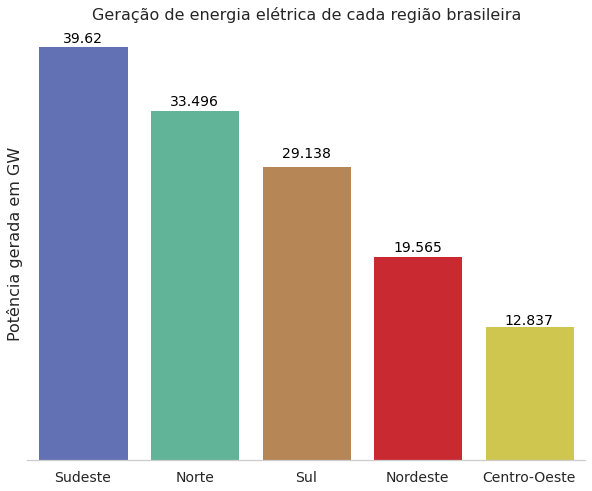

In [43]:
plt.figure(figsize=(10,8), dpi=72)
sns.set(style='whitegrid')
sns.barplot(x=['Sudeste', 'Norte', 'Sul', 'Nordeste', 'Centro-Oeste'], 
            y=[potencia_regional[2], potencia_regional[1], potencia_regional[0], potencia_regional[4], potencia_regional[3]],
            palette=['#5369c2', '#53c29d', '#c78646', '#e3101a', '#e3d839'])
plt.xlabel('')
plt.ylabel('Potência gerada em GW', size=16)
plt.xticks(size=14)
plt.yticks([],[])
plt.title('Geração de energia elétrica de cada região brasileira', fontsize=16)
plt.text(x=0, y=40, s='39.62',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=1, y=34, s='33.496',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=2, y=29, s='29.138',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=3, y=20, s='19.565',
         color='black', fontsize=14, horizontalalignment='center')
plt.text(x=4, y=13, s='12.837',
         color='black', fontsize=14, horizontalalignment='center')
sns.despine(left=True)
plt.show()